In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchaudio.transforms as T
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import timm
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
BASE_PATH = '/kaggle/input/gtzan-fma-merged'

class RandomWindowSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, df, base_path, dataset_name, window_size=128, imagenet=False, img_size=(224, 224), pretrained=True, augment=False):
        super().__init__()
        self.df = df
        self.base_path = base_path
        self.dataset_name = dataset_name
        self.window_size = window_size
        self.imagenet = imagenet
        self.img_size = img_size
        self.pretrained = pretrained
        self.augment = augment

        transform_list = []

        if pretrained:
            # if self.augment:
            #     transform_list.extend([
            #         transforms.ColorJitter(brightness=0.2, contrast=0.2),
            #         transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            #     ])
            if self.img_size:
                transform_list.append(transforms.Resize(self.img_size, interpolation=Image.BILINEAR))

            transform_list.append(transforms.ToTensor())
            
            if self.imagenet:
                transform_list.append(transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                ))
                
            self.transform = transforms.Compose(transform_list)
        else:
            self.spec_augment = self.spec_augment = nn.Sequential(
                T.FrequencyMasking(freq_mask_param=15),
                T.TimeMasking(time_mask_param=35),
            ) if self.augment else None
            # Normalize to [-1, 1]
            self.transform = lambda x: (x * 2) - 1  # input [0, 1]
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        genre = row['genre']
        rel_path = row['spectrogram_path']

        full_path = os.path.join(self.base_path, self.dataset_name, rel_path)

        spec = torch.load(full_path, weights_only=True)
        spec_len = spec.shape[-1]

        start = np.random.randint(0, spec_len - self.window_size) # Sample a random part of a spectrogram
        spec_window = spec[:, start:start + self.window_size]

        if self.pretrained:
            if self.augment:
                spec_window = T.FrequencyMasking(freq_mask_param=15)(spec_window)
                spec_window = T.TimeMasking(time_mask_param=35)(spec_window)
        
            spec_np = spec_window.numpy()
            if spec_np.shape[0] == 1:  # convert [1, H, W] to [H, W]
                spec_np = spec_np[0]
            image = Image.fromarray(spec_np).convert('RGB')
        
            tensor_img = self.transform(image).float()
        else:
            if self.augment:
                spec_window = self.spec_augment(spec_window)
            tensor_img = self.transform(spec_window).unsqueeze(0).float()

        return tensor_img, genre

class EvaluationSpectrogramDataset(Dataset):
    def __init__(self, df, base_path, dataset_name, window_size=128, img_size=(224, 224), imagenet=False, pretrained=True):
        self.df = df
        self.base_path = base_path
        self.dataset_name = dataset_name
        self.window_size = window_size
        self.img_size = img_size
        self.imagenet = imagenet
        self.pretrained = pretrained

        transform_list = []

        if self.pretrained:
            if self.img_size:
                transform_list.append(transforms.Resize(self.img_size, interpolation=Image.BILINEAR))

            transform_list.append(transforms.ToTensor())

            if self.imagenet:
                transform_list.append(transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                ))

            self.transform = transforms.Compose(transform_list)
        else:
            self.transform = lambda x: (x * 2) - 1  # [0, 1] → [-1, 1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_path, self.dataset_name, row['spectrogram_path'])
        spec = torch.load(full_path, weights_only=True)  # shape: (128, time_steps)

        spec_len = spec.shape[-1]
        target_num_windows = round(spec_len / self.window_size)
        target_len = target_num_windows * self.window_size

        # Pad if needed
        if spec_len < target_len:
            pad_amount = target_len - spec_len
            spec = F.pad(spec, (0, pad_amount))

        # Unfold into windows
        spec = spec.unfold(1, self.window_size, self.window_size)  # (128, num_windows, window_size)
        spec = spec.permute(1, 0, 2)  # (num_windows, 128, window_size)

        windows = []
        for window in spec:
            if self.pretrained:
                # Convert to image and apply transform
                spec_np = window.numpy()
                image = Image.fromarray(spec_np).convert('RGB')  # (128, window_size) → RGB image
                tensor_img = self.transform(image).float()
            else:
                tensor_img = self.transform(window).unsqueeze(0).float()  # add channel dim

            windows.append(tensor_img)

        windows = torch.stack(windows)  # shape: (num_windows, 3, H, W)
        return windows, row['genre']

In [3]:
def train_model(model, device, num_epochs, optimizer, criterion, scheduler, log_step, train_loader, val_loader):
    train_accs = []
    train_losses = []
    val_accs = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
    
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
    
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    
        scheduler.step()
        avg_loss = total_loss / total
        accuracy = correct / total
        train_accs.append(accuracy)
        train_losses.append(avg_loss)
        if epoch % log_step == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}, accuracy: {accuracy:.4f}")
    
        model.eval()
        val_loss = 0.0
        val_total = 0
    
        with torch.no_grad():
            all_preds = []
            all_labels = []
            track_preds = []
            track_labels = []
        
            for batch in val_loader:
                spectrograms, labels = batch  # (B, 10, C, H, W), labels is (B,)
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                B, num_windows, C, H, W = spectrograms.shape
        
                # Flatten windows
                flat_input = spectrograms.view(B * num_windows, C, H, W)  # (B*10, C, H, W)
        
                outputs = model(flat_input)  # (B*10, num_classes)
                preds = outputs.argmax(dim=1)  # (B*10,)
    
                loss = criterion(outputs, labels.repeat_interleave(10))
                
                val_loss += loss.item() * spectrograms.size(0)
                val_total += spectrograms.size(0)
        
                # Window-level accuracy
                all_preds.append(preds)
                all_labels.append(labels.repeat_interleave(num_windows))  # (B*10,)
        
                # Track-level accuracy via majority vote
                preds = preds.view(B, num_windows)  # (B, 10)
                mode_preds, _ = preds.mode(dim=1)   # (B,)
                track_preds.append(mode_preds)
                track_labels.append(labels)
        
            # Concatenate all batches
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)
            track_preds = torch.cat(track_preds)
            track_labels = torch.cat(track_labels)
        
            window_acc = (all_preds == all_labels).float().mean().item()
            track_acc = (track_preds == track_labels).float().mean().item()
    
            val_accs.append(window_acc)
            val_losses.append(val_loss / val_total)
    
            if epoch % log_step == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - validation per-window accuracy: {window_acc:.4f}, validation majority accuracy: {track_acc:.4f}, loss: {val_loss / val_total:.4f}")

    return train_accs, val_accs, train_losses, val_losses

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    all_preds = []
    all_labels = []
    track_preds = []
    track_labels = []

    with torch.no_grad():
        for spectrograms, labels in loader:  # (B, N, C, H, W)
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            B, num_windows, C, H, W = spectrograms.shape

            # Flatten windows
            flat_input = spectrograms.view(B * num_windows, C, H, W)  # (B*N, C, H, W)
            flat_labels = labels.repeat_interleave(num_windows)       # (B*N,)

            outputs = model(flat_input)                                # (B*N, num_classes)
            loss = criterion(outputs, flat_labels)

            preds = outputs.argmax(dim=1)  # (B*N,)

            total_loss += loss.item() * B
            total_samples += B

            # Window-level
            all_preds.append(preds.cpu())
            all_labels.append(flat_labels.cpu())

            # Track-level (majority vote)
            preds_reshaped = preds.view(B, num_windows)               # (B, N)
            majority_preds, _ = preds_reshaped.mode(dim=1)           # (B,)
            track_preds.append(majority_preds.cpu())
            track_labels.append(labels.cpu())

    # Concatenate
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    track_preds = torch.cat(track_preds)
    track_labels = torch.cat(track_labels)

    # Accuracy
    window_acc = (all_preds == all_labels).float().mean().item()
    track_acc = (track_preds == track_labels).float().mean().item()

    # Precision/Recall/F1 (track-level)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    print("Evaluation:")
    print(f"  - Window Accuracy: {window_acc:.4f}")
    print(f"  - Track Accuracy:  {track_acc:.4f}")
    print(f"  - Precision:       {precision:.4f}")
    print(f"  - Recall:          {recall:.4f}")
    print(f"  - F1 Score:        {f1:.4f}")

    return {
        'window_acc': window_acc,
        'track_acc': track_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'loss': total_loss / total_samples
    }

In [4]:
class GenreCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2), # (64, 64)

            torch.nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2), # (32, 32)

            torch.nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2), # (16, 16)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            torch.nn.Linear(256, 10)
        )

    def forward(self, x): # x is expected to have shape (128, 128)
        x = self.features(x)
        x = self.classifier(x)

        return x

In [5]:
df_gtzan = pd.read_csv(os.path.join(BASE_PATH, 'gtzan', 'gtzan_spectrograms.csv'))

le = LabelEncoder()

df_gtzan['genre'] = le.fit_transform(df_gtzan['genre'])
genres_gtzan = le.classes_

train_val_df_gtzan, test_df_gtzan = train_test_split(df_gtzan, test_size=0.2, random_state=42, stratify=df_gtzan['genre'])

train_df_gtzan, val_df_gtzan = train_test_split(train_val_df_gtzan, test_size=0.2, random_state=42, stratify=train_val_df_gtzan['genre'])

# train = 64%, val = 16%, test = 20%
print(train_df_gtzan.shape)
print(val_df_gtzan.shape)
print(test_df_gtzan.shape)

(639, 3)
(160, 3)
(200, 3)


# GTZAN - Custom model: with and without augmentation #

In [6]:
ds_train_gtzan_cnn = RandomWindowSpectrogramDataset(train_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=False, img_size=None, pretrained=False)
ds_val_gtzan_cnn = EvaluationSpectrogramDataset(val_df_gtzan, BASE_PATH, 'gtzan', window_size=128, img_size=None, imagenet=False, pretrained=False)
ds_test_gtzan_cnn = EvaluationSpectrogramDataset(test_df_gtzan, BASE_PATH, 'gtzan', window_size=128, img_size=None, imagenet=False, pretrained=False)

loader_train_gtzan_cnn = DataLoader(ds_train_gtzan_cnn, batch_size=64, shuffle=True)
loader_val_gtzan_cnn = DataLoader(ds_val_gtzan_cnn, batch_size=8, shuffle=False)
loader_test_gtzan_cnn = DataLoader(ds_test_gtzan_cnn, batch_size=8, shuffle=False)

In [35]:
model = GenreCNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=100)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 100, optimizer, criterion, scheduler, 5, loader_train_gtzan_cnn, loader_val_gtzan_cnn)

Epoch 1/100 - loss: 4.2020, accuracy: 0.1377
Epoch 1/100 - validation per-window accuracy: 0.1887, validation majority accuracy: 0.1813, loss: 2.2878
Epoch 6/100 - loss: 1.8544, accuracy: 0.3099
Epoch 6/100 - validation per-window accuracy: 0.3487, validation majority accuracy: 0.3750, loss: 1.8026
Epoch 11/100 - loss: 1.5675, accuracy: 0.4069
Epoch 11/100 - validation per-window accuracy: 0.4544, validation majority accuracy: 0.5125, loss: 1.5064
Epoch 16/100 - loss: 1.4154, accuracy: 0.4914
Epoch 16/100 - validation per-window accuracy: 0.5412, validation majority accuracy: 0.6062, loss: 1.2992
Epoch 21/100 - loss: 1.3085, accuracy: 0.5336
Epoch 21/100 - validation per-window accuracy: 0.5981, validation majority accuracy: 0.6687, loss: 1.1952
Epoch 26/100 - loss: 1.2511, accuracy: 0.5603
Epoch 26/100 - validation per-window accuracy: 0.6012, validation majority accuracy: 0.6375, loss: 1.1583
Epoch 31/100 - loss: 1.1194, accuracy: 0.6041
Epoch 31/100 - validation per-window accuracy:

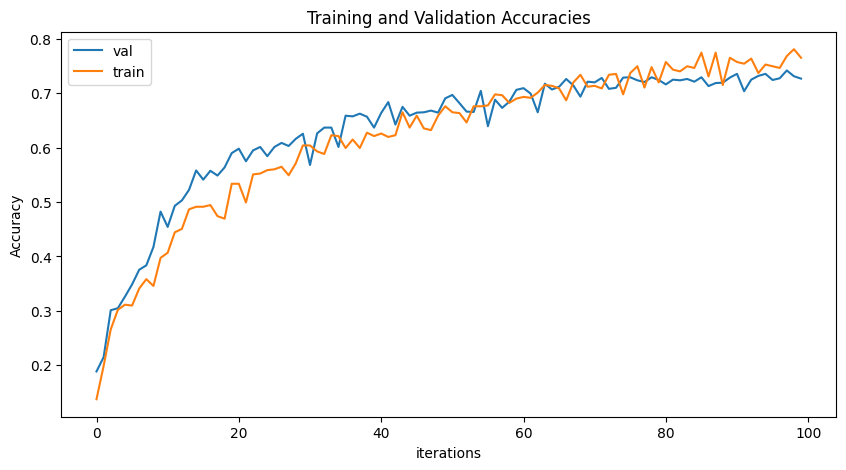

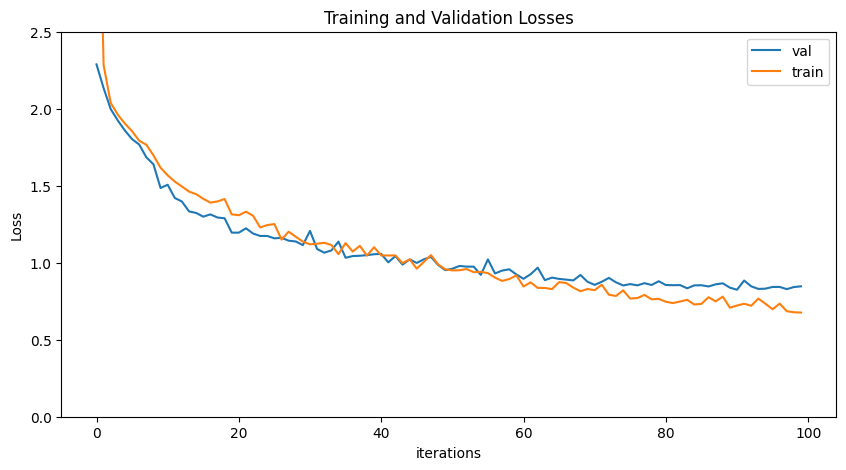

In [36]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("gtzan_custom_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.ylim((0, 2.5))
plt.legend()
plt.savefig("gtzan_custom_loss.png")
plt.show()

In [37]:
results = evaluate(model, loader_test_gtzan_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.7295
  - Track Accuracy:  0.7850
  - Precision:       0.7323
  - Recall:          0.7295
  - F1 Score:        0.7296


In [38]:
ds_train_gtzan_cnn = RandomWindowSpectrogramDataset(train_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=False, img_size=None, pretrained=False, augment=True)
ds_val_gtzan_cnn = EvaluationSpectrogramDataset(val_df_gtzan, BASE_PATH, 'gtzan', window_size=128, img_size=None, imagenet=False, pretrained=False)
ds_test_gtzan_cnn = EvaluationSpectrogramDataset(test_df_gtzan, BASE_PATH, 'gtzan', window_size=128, img_size=None, imagenet=False, pretrained=False)

loader_train_gtzan_cnn = DataLoader(ds_train_gtzan_cnn, batch_size=64, shuffle=True)
loader_val_gtzan_cnn = DataLoader(ds_val_gtzan_cnn, batch_size=8, shuffle=False)
loader_test_gtzan_cnn = DataLoader(ds_test_gtzan_cnn, batch_size=8, shuffle=False)

In [42]:
model = GenreCNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=100)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=5e-6)
train_accs, val_accs, train_losses, val_losses = train_model(model, device, 100, optimizer, criterion, scheduler, 5, loader_train_gtzan_cnn, loader_val_gtzan_cnn)

Epoch 1/100 - loss: 3.3367, accuracy: 0.1205
Epoch 1/100 - validation per-window accuracy: 0.2069, validation majority accuracy: 0.2188, loss: 2.2826
Epoch 6/100 - loss: 1.7915, accuracy: 0.3505
Epoch 6/100 - validation per-window accuracy: 0.3819, validation majority accuracy: 0.4000, loss: 1.6493
Epoch 11/100 - loss: 1.5639, accuracy: 0.4100
Epoch 11/100 - validation per-window accuracy: 0.5000, validation majority accuracy: 0.5437, loss: 1.4424
Epoch 16/100 - loss: 1.4464, accuracy: 0.4429
Epoch 16/100 - validation per-window accuracy: 0.5531, validation majority accuracy: 0.6062, loss: 1.3081
Epoch 21/100 - loss: 1.3412, accuracy: 0.4930
Epoch 21/100 - validation per-window accuracy: 0.5775, validation majority accuracy: 0.6062, loss: 1.1968
Epoch 26/100 - loss: 1.3071, accuracy: 0.5180
Epoch 26/100 - validation per-window accuracy: 0.6262, validation majority accuracy: 0.6562, loss: 1.1053
Epoch 31/100 - loss: 1.2205, accuracy: 0.5618
Epoch 31/100 - validation per-window accuracy:

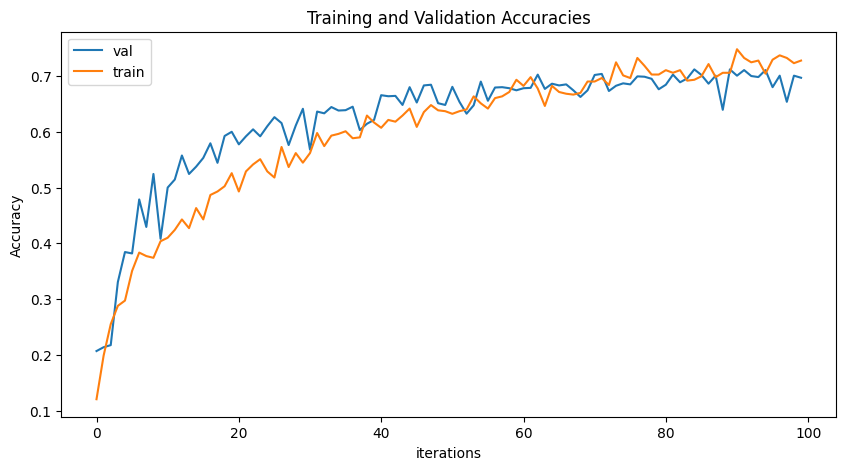

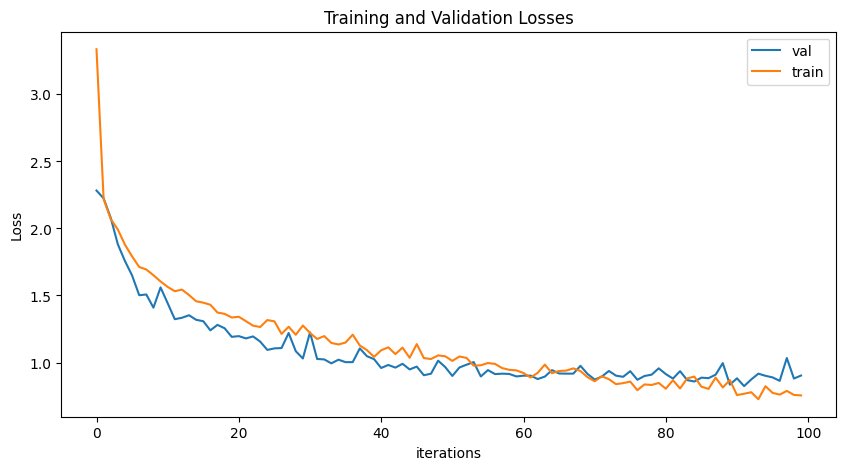

In [46]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("gtzan_custom_acc_aug.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("gtzan_custom_loss_aug.png")
plt.show()

In [45]:
results = evaluate(model, loader_test_gtzan_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.7090
  - Track Accuracy:  0.7700
  - Precision:       0.7270
  - Recall:          0.7090
  - F1 Score:        0.7071


# GTZAN - ResNet model: with and without augmentation #

In [49]:
ds_train_gtzan_cnn = RandomWindowSpectrogramDataset(train_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_val_gtzan_cnn = EvaluationSpectrogramDataset(val_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_test_gtzan_cnn = EvaluationSpectrogramDataset(test_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)

loader_train_gtzan_cnn = DataLoader(ds_train_gtzan_cnn, batch_size=64, shuffle=True)
loader_val_gtzan_cnn = DataLoader(ds_val_gtzan_cnn, batch_size=8, shuffle=False)
loader_test_gtzan_cnn = DataLoader(ds_test_gtzan_cnn, batch_size=8, shuffle=False)

In [50]:
model = timm.create_model('resnet18', pretrained=True, num_classes=10).to(device)
    
criterion = torch.nn.CrossEntropyLoss()

# classifier_named_params = list(model.get_classifier().named_parameters())
# classifier_param_names = set(n for n, _ in classifier_named_params)

# backbone_params = [
#     p for n, p in model.named_parameters() 
#     if p.requires_grad and "fc" not in n  # Exclude the 'fc' layers from backbone
# ]

# classifier_params = [
#     p for n, p in model.get_classifier().named_parameters() 
#     if p.requires_grad  # Only include parameters that require gradients
# ]

# optimizer = torch.optim.AdamW([
#     {'params': backbone_params, 'lr': 1e-4, 'weight_decay': 1e-5},
#     {'params': classifier_params, 'lr': 1e-3, 'weight_decay': 1e-5}
# ])

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)


scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 30, optimizer, criterion, scheduler, 1, loader_train_gtzan_cnn, loader_val_gtzan_cnn)

Epoch 1/30 - loss: 2.1692, accuracy: 0.2300
Epoch 1/30 - validation per-window accuracy: 0.3119, validation majority accuracy: 0.3187, loss: 2.1010
Epoch 2/30 - loss: 1.7623, accuracy: 0.4570
Epoch 2/30 - validation per-window accuracy: 0.4806, validation majority accuracy: 0.5125, loss: 1.7457
Epoch 3/30 - loss: 1.4809, accuracy: 0.5430
Epoch 3/30 - validation per-window accuracy: 0.5075, validation majority accuracy: 0.5188, loss: 1.3989
Epoch 4/30 - loss: 1.2295, accuracy: 0.6103
Epoch 4/30 - validation per-window accuracy: 0.5906, validation majority accuracy: 0.6313, loss: 1.1804
Epoch 5/30 - loss: 1.0460, accuracy: 0.6635
Epoch 5/30 - validation per-window accuracy: 0.6850, validation majority accuracy: 0.7563, loss: 0.9783
Epoch 6/30 - loss: 0.9441, accuracy: 0.6745
Epoch 6/30 - validation per-window accuracy: 0.6856, validation majority accuracy: 0.7312, loss: 0.9290
Epoch 7/30 - loss: 0.8039, accuracy: 0.7371
Epoch 7/30 - validation per-window accuracy: 0.7081, validation majo

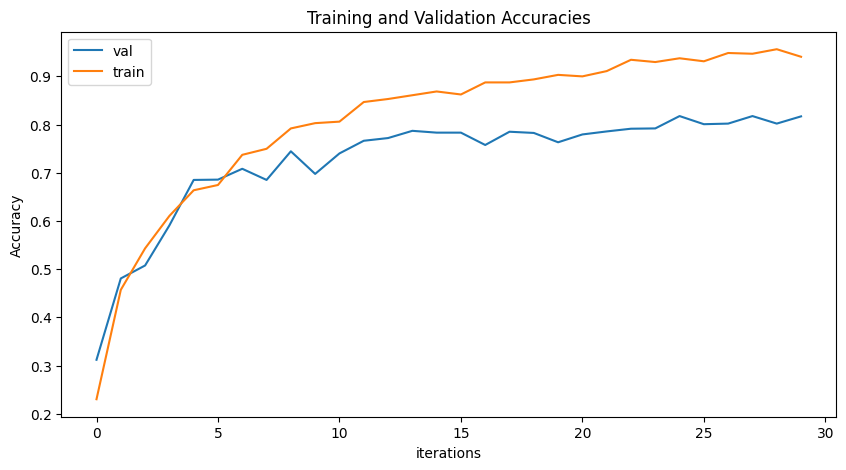

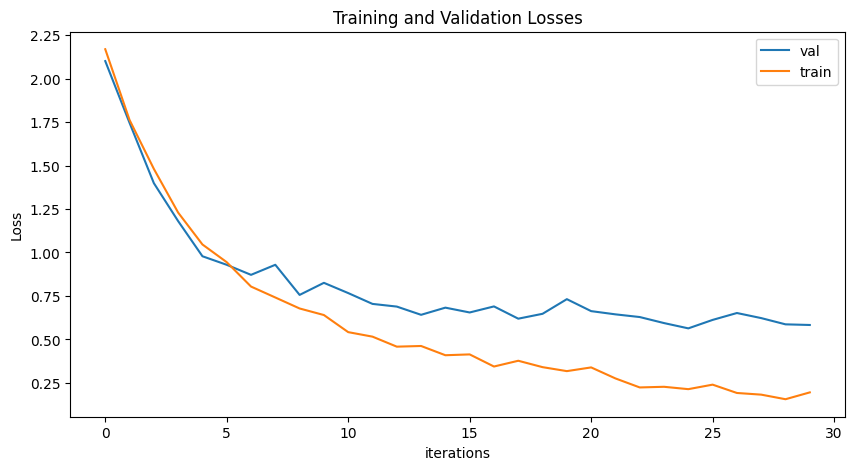

In [51]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("gtzan_resnet_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("gtzan_resnet_loss.png")
plt.show()

In [52]:
results = evaluate_model(model, loader_test_gtzan_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.7635
  - Track Accuracy:  0.8350
  - Precision:       0.7765
  - Recall:          0.7635
  - F1 Score:        0.7612


In [53]:
ds_train_gtzan_cnn = RandomWindowSpectrogramDataset(train_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True, augment=True)
ds_val_gtzan_cnn = EvaluationSpectrogramDataset(val_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_test_gtzan_cnn = EvaluationSpectrogramDataset(test_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)

loader_train_gtzan_cnn = DataLoader(ds_train_gtzan_cnn, batch_size=64, shuffle=True)
loader_val_gtzan_cnn = DataLoader(ds_val_gtzan_cnn, batch_size=8, shuffle=False)
loader_test_gtzan_cnn = DataLoader(ds_test_gtzan_cnn, batch_size=8, shuffle=False)

In [54]:
model = timm.create_model('resnet18', pretrained=True, num_classes=10).to(device)
    
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 30, optimizer, criterion, scheduler, 1, loader_train_gtzan_cnn, loader_val_gtzan_cnn)

Epoch 1/30 - loss: 2.2090, accuracy: 0.2113
Epoch 1/30 - validation per-window accuracy: 0.3450, validation majority accuracy: 0.4000, loss: 2.1429
Epoch 2/30 - loss: 1.8867, accuracy: 0.3928
Epoch 2/30 - validation per-window accuracy: 0.5362, validation majority accuracy: 0.5750, loss: 1.6878
Epoch 3/30 - loss: 1.6023, accuracy: 0.4444
Epoch 3/30 - validation per-window accuracy: 0.5531, validation majority accuracy: 0.6000, loss: 1.4166
Epoch 4/30 - loss: 1.3275, accuracy: 0.5728
Epoch 4/30 - validation per-window accuracy: 0.5838, validation majority accuracy: 0.6750, loss: 1.2683
Epoch 5/30 - loss: 1.1974, accuracy: 0.6056
Epoch 5/30 - validation per-window accuracy: 0.6106, validation majority accuracy: 0.6687, loss: 1.1076
Epoch 6/30 - loss: 1.0976, accuracy: 0.6369
Epoch 6/30 - validation per-window accuracy: 0.6081, validation majority accuracy: 0.6375, loss: 1.1266
Epoch 7/30 - loss: 0.9940, accuracy: 0.6510
Epoch 7/30 - validation per-window accuracy: 0.6869, validation majo

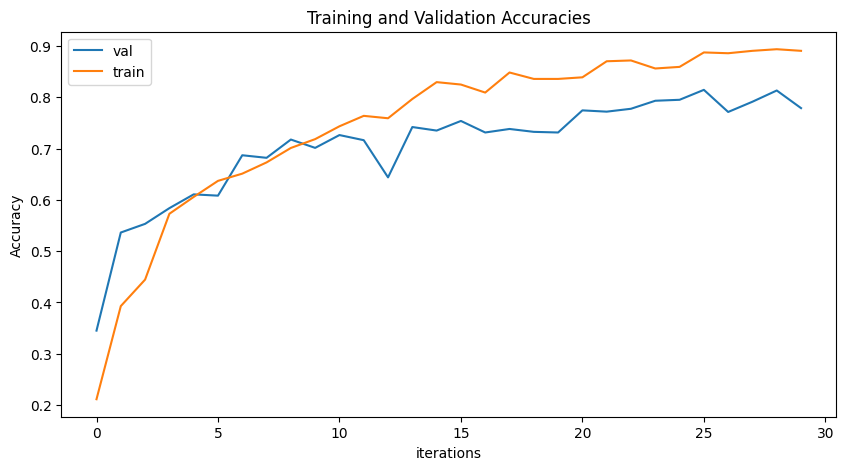

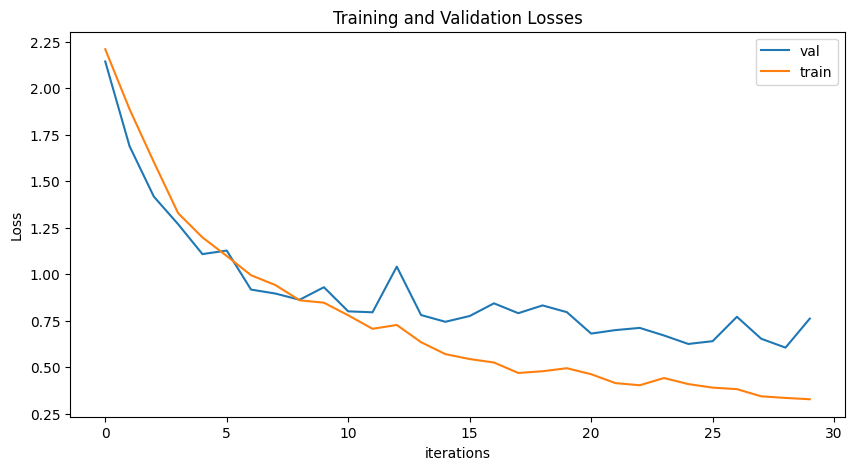

In [55]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("gtzan_resnet_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("gtzan_resnet_loss.png")
plt.show()

In [56]:
results = evaluate_model(model, loader_test_gtzan_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.7510
  - Track Accuracy:  0.8000
  - Precision:       0.7724
  - Recall:          0.7510
  - F1 Score:        0.7497


# GTZAN - DeiT Tiny model: with and without augmentation #

In [14]:
ds_train_gtzan_cnn = RandomWindowSpectrogramDataset(train_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_val_gtzan_cnn = EvaluationSpectrogramDataset(val_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_test_gtzan_cnn = EvaluationSpectrogramDataset(test_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)

loader_train_gtzan_cnn = DataLoader(ds_train_gtzan_cnn, batch_size=64, shuffle=True)
loader_val_gtzan_cnn = DataLoader(ds_val_gtzan_cnn, batch_size=8, shuffle=False)
loader_test_gtzan_cnn = DataLoader(ds_test_gtzan_cnn, batch_size=8, shuffle=False)

In [15]:
model = timm.create_model("deit_tiny_patch16_224", pretrained=True, num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=50)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 50, optimizer, criterion, scheduler, 1, loader_train_gtzan_cnn, loader_val_gtzan_cnn)

Epoch 1/50 - loss: 2.3377, accuracy: 0.1299
Epoch 1/50 - validation per-window accuracy: 0.2188, validation majority accuracy: 0.2250, loss: 2.4320
Epoch 2/50 - loss: 1.9739, accuracy: 0.2457
Epoch 2/50 - validation per-window accuracy: 0.3388, validation majority accuracy: 0.3250, loss: 1.7644
Epoch 3/50 - loss: 1.8556, accuracy: 0.3036
Epoch 3/50 - validation per-window accuracy: 0.4038, validation majority accuracy: 0.4062, loss: 1.6807
Epoch 4/50 - loss: 1.6580, accuracy: 0.3756
Epoch 4/50 - validation per-window accuracy: 0.4069, validation majority accuracy: 0.4125, loss: 1.5717
Epoch 5/50 - loss: 1.5750, accuracy: 0.4397
Epoch 5/50 - validation per-window accuracy: 0.4606, validation majority accuracy: 0.5375, loss: 1.5176
Epoch 6/50 - loss: 1.5255, accuracy: 0.4241
Epoch 6/50 - validation per-window accuracy: 0.3819, validation majority accuracy: 0.3812, loss: 1.5477
Epoch 7/50 - loss: 1.4924, accuracy: 0.4257
Epoch 7/50 - validation per-window accuracy: 0.5181, validation majo

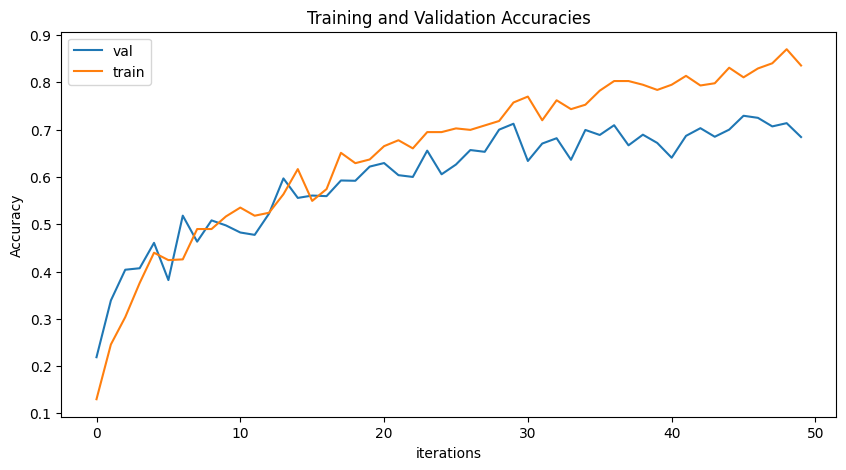

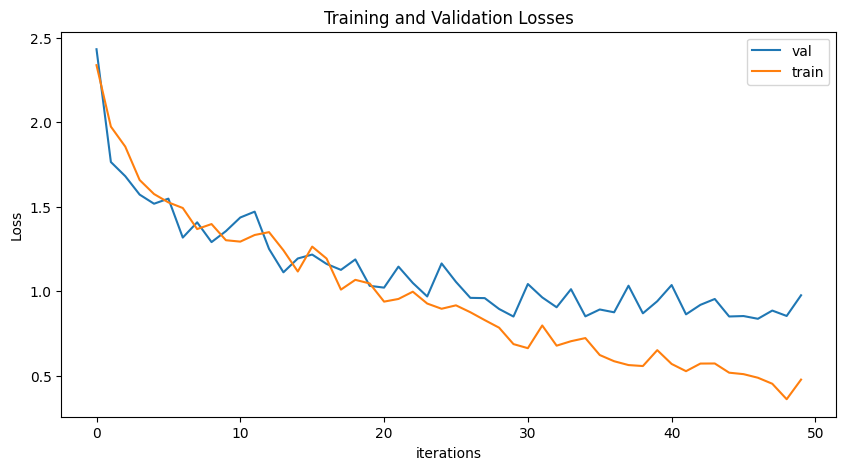

In [16]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("gtzan_vit_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("gtzan_vit_loss.png")
plt.show()

In [17]:
results = evaluate_model(model, loader_test_gtzan_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.6720
  - Track Accuracy:  0.7400
  - Precision:       0.7267
  - Recall:          0.6720
  - F1 Score:        0.6719


In [10]:
ds_train_gtzan_cnn = RandomWindowSpectrogramDataset(train_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True, augment=True)
ds_val_gtzan_cnn = EvaluationSpectrogramDataset(val_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_test_gtzan_cnn = EvaluationSpectrogramDataset(test_df_gtzan, BASE_PATH, 'gtzan', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)

loader_train_gtzan_cnn = DataLoader(ds_train_gtzan_cnn, batch_size=64, shuffle=True)
loader_val_gtzan_cnn = DataLoader(ds_val_gtzan_cnn, batch_size=8, shuffle=False)
loader_test_gtzan_cnn = DataLoader(ds_test_gtzan_cnn, batch_size=8, shuffle=False)

In [11]:
model = timm.create_model("deit_tiny_patch16_224", pretrained=True, num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=50)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 50, optimizer, criterion, scheduler, 1, loader_train_gtzan_cnn, loader_val_gtzan_cnn)

Epoch 1/50 - loss: 2.3278, accuracy: 0.1659
Epoch 1/50 - validation per-window accuracy: 0.1887, validation majority accuracy: 0.1875, loss: 2.1091
Epoch 2/50 - loss: 1.9114, accuracy: 0.2879
Epoch 2/50 - validation per-window accuracy: 0.4181, validation majority accuracy: 0.4688, loss: 1.6671
Epoch 3/50 - loss: 1.8461, accuracy: 0.3239
Epoch 3/50 - validation per-window accuracy: 0.3606, validation majority accuracy: 0.3688, loss: 1.6604
Epoch 4/50 - loss: 1.7529, accuracy: 0.3646
Epoch 4/50 - validation per-window accuracy: 0.3137, validation majority accuracy: 0.2938, loss: 1.7600
Epoch 5/50 - loss: 1.7134, accuracy: 0.3709
Epoch 5/50 - validation per-window accuracy: 0.4400, validation majority accuracy: 0.4813, loss: 1.5407
Epoch 6/50 - loss: 1.6490, accuracy: 0.3740
Epoch 6/50 - validation per-window accuracy: 0.4038, validation majority accuracy: 0.4188, loss: 1.5749
Epoch 7/50 - loss: 1.6119, accuracy: 0.4194
Epoch 7/50 - validation per-window accuracy: 0.4356, validation majo

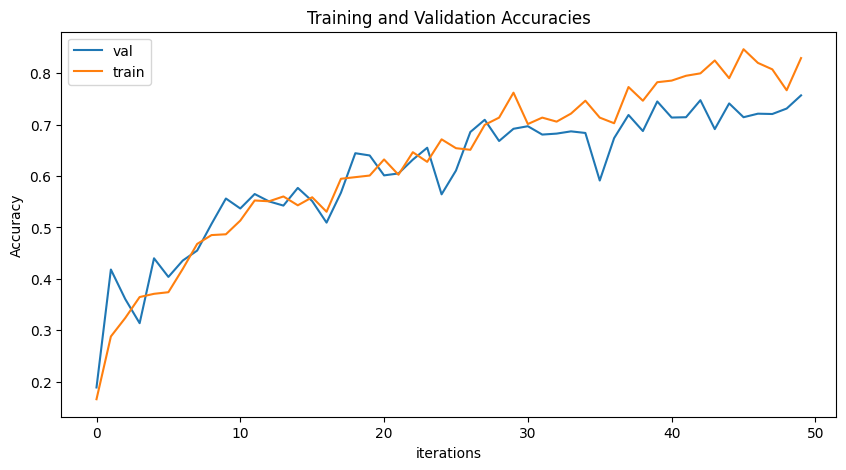

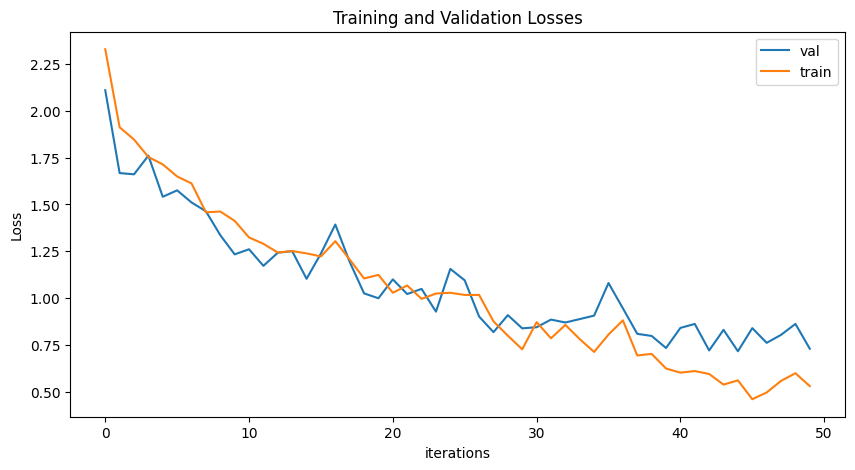

In [12]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("gtzan_vit_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("gtzan_vit_loss.png")
plt.show()

In [13]:
results = evaluate_model(model, loader_test_gtzan_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.7165
  - Track Accuracy:  0.7650
  - Precision:       0.7305
  - Recall:          0.7165
  - F1 Score:        0.7154


# FMA - Custom model: with and without augmentation #

In [18]:
df_fma = pd.read_csv(os.path.join(BASE_PATH, 'fma', 'fma_spectrograms.csv'))

le = LabelEncoder()

df_fma['genre'] = le.fit_transform(df_fma['genre'])
genres_fma = le.classes_

train_val_df_fma, test_df_fma = train_test_split(df_fma, test_size=0.2, random_state=42, stratify=df_fma['genre'])

train_df_fma, val_df_fma = train_test_split(train_val_df_fma, test_size=0.2, random_state=42, stratify=train_val_df_fma['genre'])

# train = 64%, val = 16%, test = 20%
print(train_df_fma.shape)
print(val_df_fma.shape)
print(test_df_fma.shape)

(5112, 3)
(1278, 3)
(1598, 3)


In [19]:
ds_train_fma_cnn = RandomWindowSpectrogramDataset(train_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=False, img_size=None, pretrained=False)
ds_val_fma_cnn = EvaluationSpectrogramDataset(val_df_fma, BASE_PATH, 'fma', window_size=128, img_size=None, imagenet=False, pretrained=False)
ds_test_fma_cnn = EvaluationSpectrogramDataset(test_df_fma, BASE_PATH, 'fma', window_size=128, img_size=None, imagenet=False, pretrained=False)

loader_train_fma_cnn = DataLoader(ds_train_fma_cnn, batch_size=128, shuffle=True)
loader_val_fma_cnn = DataLoader(ds_val_fma_cnn, batch_size=16, shuffle=False)
loader_test_fma_cnn = DataLoader(ds_test_fma_cnn, batch_size=16, shuffle=False)

In [20]:
model = GenreCNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=20)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 20, optimizer, criterion, scheduler, 1, loader_train_fma_cnn, loader_val_fma_cnn)

Epoch 1/20 - loss: 2.6355, accuracy: 0.1929
Epoch 1/20 - validation per-window accuracy: 0.2526, validation majority accuracy: 0.2613, loss: 1.9547
Epoch 2/20 - loss: 1.9141, accuracy: 0.2819
Epoch 2/20 - validation per-window accuracy: 0.3250, validation majority accuracy: 0.3365, loss: 1.8411
Epoch 3/20 - loss: 1.8512, accuracy: 0.3124
Epoch 3/20 - validation per-window accuracy: 0.3482, validation majority accuracy: 0.3584, loss: 1.7815
Epoch 4/20 - loss: 1.7822, accuracy: 0.3378
Epoch 4/20 - validation per-window accuracy: 0.3947, validation majority accuracy: 0.4233, loss: 1.7169
Epoch 5/20 - loss: 1.7536, accuracy: 0.3545
Epoch 5/20 - validation per-window accuracy: 0.3838, validation majority accuracy: 0.3975, loss: 1.6998
Epoch 6/20 - loss: 1.7184, accuracy: 0.3695
Epoch 6/20 - validation per-window accuracy: 0.4165, validation majority accuracy: 0.4444, loss: 1.6782
Epoch 7/20 - loss: 1.7019, accuracy: 0.3772
Epoch 7/20 - validation per-window accuracy: 0.4066, validation majo

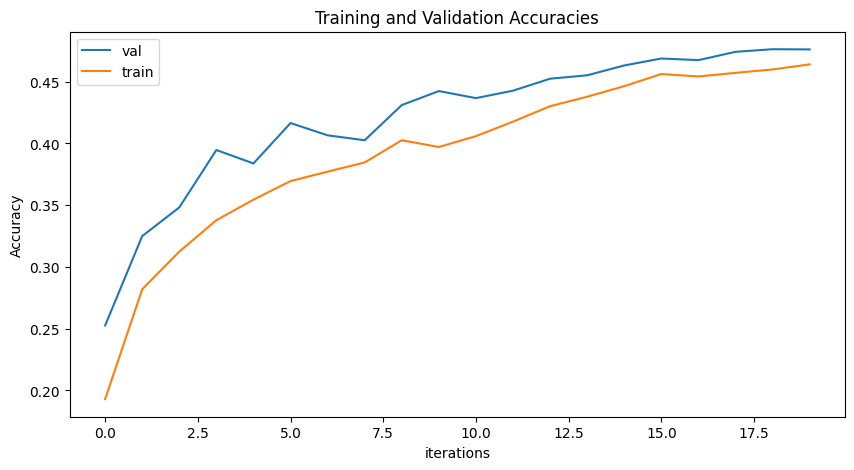

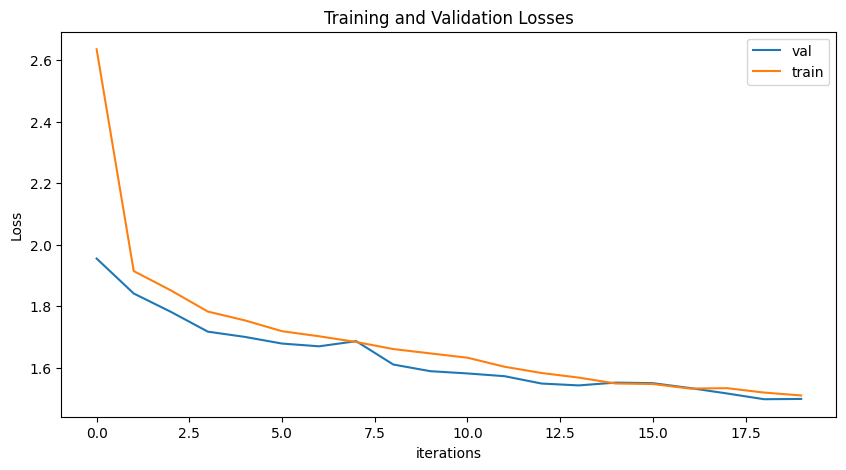

In [21]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fma_cnn_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("fma_cnn_loss.png")
plt.show()

In [22]:
results = evaluate_model(model, loader_test_fma_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.4899
  - Track Accuracy:  0.5200
  - Precision:       0.4784
  - Recall:          0.4901
  - F1 Score:        0.4777


In [23]:
ds_train_fma_cnn = RandomWindowSpectrogramDataset(train_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=False, img_size=None, pretrained=False, augment=True)
ds_val_fma_cnn = EvaluationSpectrogramDataset(val_df_fma, BASE_PATH, 'fma', window_size=128, img_size=None, imagenet=False, pretrained=False)
ds_test_fma_cnn = EvaluationSpectrogramDataset(test_df_fma, BASE_PATH, 'fma', window_size=128, img_size=None, imagenet=False, pretrained=False)

loader_train_fma_cnn = DataLoader(ds_train_fma_cnn, batch_size=128, shuffle=True)
loader_val_fma_cnn = DataLoader(ds_val_fma_cnn, batch_size=16, shuffle=False)
loader_test_fma_cnn = DataLoader(ds_test_fma_cnn, batch_size=16, shuffle=False)

In [24]:
model = GenreCNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=30)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 30, optimizer, criterion, scheduler, 1, loader_train_fma_cnn, loader_val_fma_cnn)

Epoch 1/30 - loss: 2.5533, accuracy: 0.1802
Epoch 1/30 - validation per-window accuracy: 0.2592, validation majority accuracy: 0.2746, loss: 1.9537
Epoch 2/30 - loss: 1.9773, accuracy: 0.2457
Epoch 2/30 - validation per-window accuracy: 0.3119, validation majority accuracy: 0.3318, loss: 1.8665
Epoch 3/30 - loss: 1.9042, accuracy: 0.2770
Epoch 3/30 - validation per-window accuracy: 0.2697, validation majority accuracy: 0.2778, loss: 1.9061
Epoch 4/30 - loss: 1.8465, accuracy: 0.3001
Epoch 4/30 - validation per-window accuracy: 0.3120, validation majority accuracy: 0.3286, loss: 1.8820
Epoch 5/30 - loss: 1.8053, accuracy: 0.3312
Epoch 5/30 - validation per-window accuracy: 0.3779, validation majority accuracy: 0.3951, loss: 1.7211
Epoch 6/30 - loss: 1.7697, accuracy: 0.3484
Epoch 6/30 - validation per-window accuracy: 0.3606, validation majority accuracy: 0.3740, loss: 1.7875
Epoch 7/30 - loss: 1.7451, accuracy: 0.3640
Epoch 7/30 - validation per-window accuracy: 0.4114, validation majo

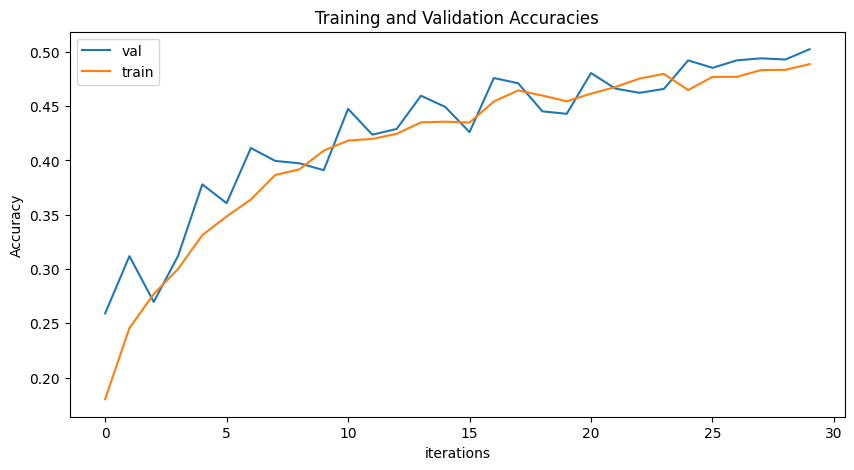

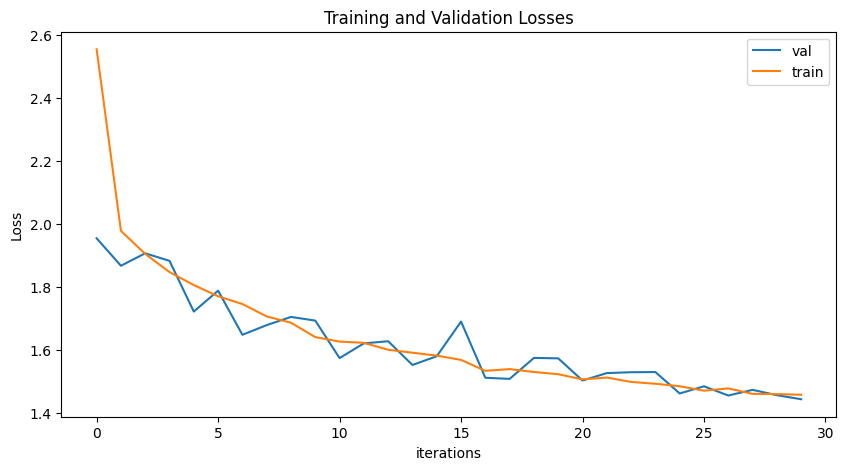

In [25]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fma_cnn_acc_aug.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("fma_cnn_loss_aug.png")
plt.show()

In [26]:
results = evaluate_model(model, loader_test_fma_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.5205
  - Track Accuracy:  0.5588
  - Precision:       0.5033
  - Recall:          0.5207
  - F1 Score:        0.5050


# FMA - ResNet model: with and without augmentation #

In [30]:
ds_train_fma_cnn = RandomWindowSpectrogramDataset(train_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_val_fma_cnn = EvaluationSpectrogramDataset(val_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_test_fma_cnn = EvaluationSpectrogramDataset(test_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)

loader_train_fma_cnn = DataLoader(ds_train_fma_cnn, batch_size=128, shuffle=True)
loader_val_fma_cnn = DataLoader(ds_val_fma_cnn, batch_size=16, shuffle=False)
loader_test_fma_cnn = DataLoader(ds_test_fma_cnn, batch_size=16, shuffle=False)

In [34]:
model = timm.create_model('resnet18', pretrained=True, num_classes=10).to(device)
    
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 6, optimizer, criterion, scheduler, 1, loader_train_fma_cnn, loader_val_fma_cnn)

Epoch 1/6 - loss: 1.7441, accuracy: 0.3824
Epoch 1/6 - validation per-window accuracy: 0.4587, validation majority accuracy: 0.4922, loss: 1.5395
Epoch 2/6 - loss: 1.3630, accuracy: 0.5286
Epoch 2/6 - validation per-window accuracy: 0.4785, validation majority accuracy: 0.5164, loss: 1.4751
Epoch 3/6 - loss: 1.2616, accuracy: 0.5651
Epoch 3/6 - validation per-window accuracy: 0.5182, validation majority accuracy: 0.5501, loss: 1.3823
Epoch 4/6 - loss: 1.1929, accuracy: 0.5841
Epoch 4/6 - validation per-window accuracy: 0.5351, validation majority accuracy: 0.5720, loss: 1.3121
Epoch 5/6 - loss: 1.1235, accuracy: 0.6176
Epoch 5/6 - validation per-window accuracy: 0.5380, validation majority accuracy: 0.5767, loss: 1.2967
Epoch 6/6 - loss: 1.0865, accuracy: 0.6295
Epoch 6/6 - validation per-window accuracy: 0.5667, validation majority accuracy: 0.6182, loss: 1.2667


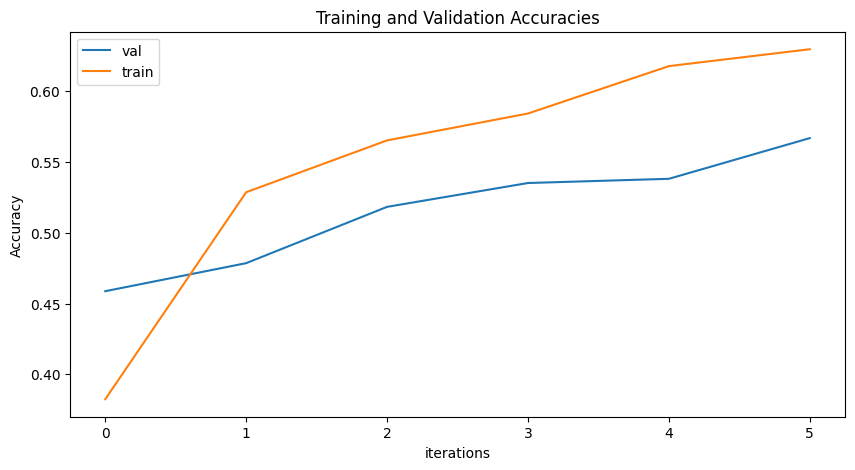

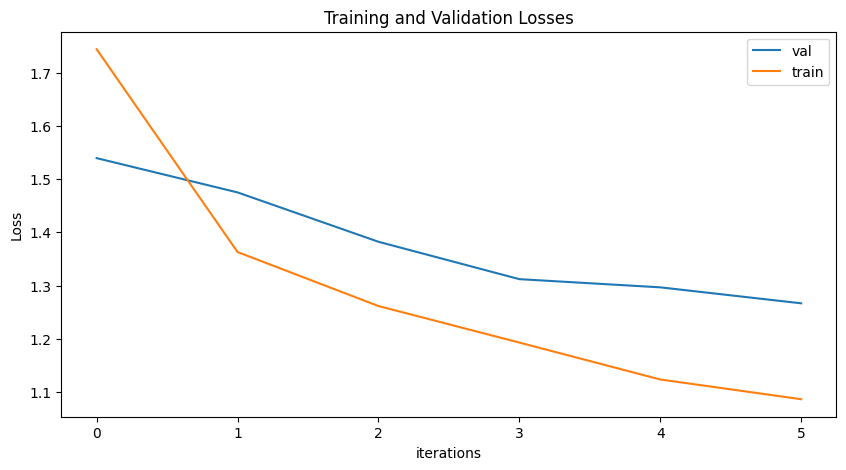

In [35]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fma_resnet_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("fma_resnet_loss.png")
plt.show()

In [36]:
results = evaluate_model(model, loader_test_fma_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.5759
  - Track Accuracy:  0.6258
  - Precision:       0.5810
  - Recall:          0.5760
  - F1 Score:        0.5727


In [37]:
ds_train_fma_cnn = RandomWindowSpectrogramDataset(train_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True, augment=True)
ds_val_fma_cnn = EvaluationSpectrogramDataset(val_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_test_fma_cnn = EvaluationSpectrogramDataset(test_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)

loader_train_fma_cnn = DataLoader(ds_train_fma_cnn, batch_size=128, shuffle=True)
loader_val_fma_cnn = DataLoader(ds_val_fma_cnn, batch_size=16, shuffle=False)
loader_test_fma_cnn = DataLoader(ds_test_fma_cnn, batch_size=16, shuffle=False)

In [38]:
model = timm.create_model('resnet18', pretrained=True, num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 10, optimizer, criterion, scheduler, 1, loader_train_fma_cnn, loader_val_fma_cnn)

Epoch 1/10 - loss: 1.8436, accuracy: 0.3404
Epoch 1/10 - validation per-window accuracy: 0.4126, validation majority accuracy: 0.4468, loss: 1.6371
Epoch 2/10 - loss: 1.4962, accuracy: 0.4718
Epoch 2/10 - validation per-window accuracy: 0.4508, validation majority accuracy: 0.4828, loss: 1.5532
Epoch 3/10 - loss: 1.3793, accuracy: 0.5129
Epoch 3/10 - validation per-window accuracy: 0.5023, validation majority accuracy: 0.5329, loss: 1.4043
Epoch 4/10 - loss: 1.3213, accuracy: 0.5397
Epoch 4/10 - validation per-window accuracy: 0.5052, validation majority accuracy: 0.5438, loss: 1.4408
Epoch 5/10 - loss: 1.2684, accuracy: 0.5595
Epoch 5/10 - validation per-window accuracy: 0.5348, validation majority accuracy: 0.5649, loss: 1.3545
Epoch 6/10 - loss: 1.2451, accuracy: 0.5661
Epoch 6/10 - validation per-window accuracy: 0.4962, validation majority accuracy: 0.5156, loss: 1.4668
Epoch 7/10 - loss: 1.2035, accuracy: 0.5802
Epoch 7/10 - validation per-window accuracy: 0.5557, validation majo

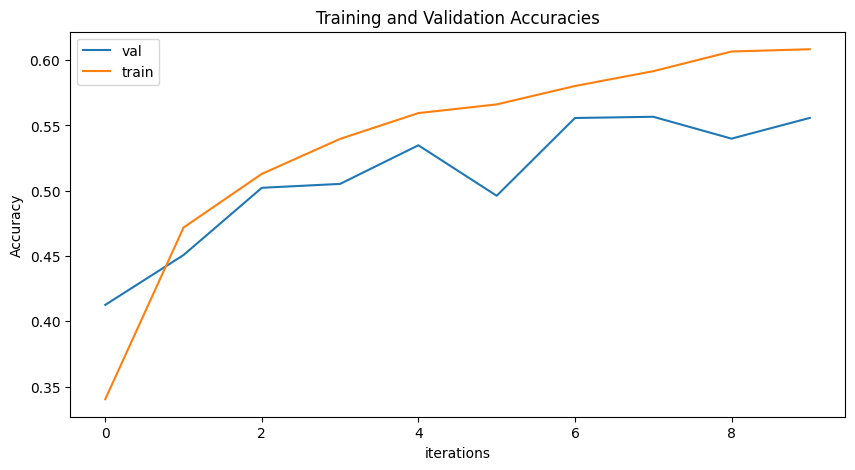

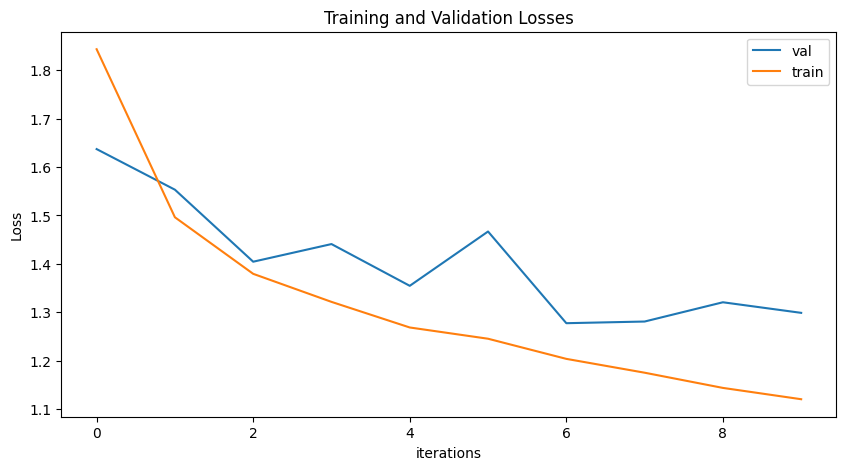

In [39]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fma_resnet_acc_aug.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("fma_resnet_loss_aug.png")
plt.show()

In [40]:
results = evaluate_model(model, loader_test_fma_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.5624
  - Track Accuracy:  0.5876
  - Precision:       0.5602
  - Recall:          0.5627
  - F1 Score:        0.5535


# FMA - DeiT model: with and without augmentation #

In [45]:
ds_train_fma_cnn = RandomWindowSpectrogramDataset(train_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_val_fma_cnn = EvaluationSpectrogramDataset(val_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_test_fma_cnn = EvaluationSpectrogramDataset(test_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)

loader_train_fma_cnn = DataLoader(ds_train_fma_cnn, batch_size=128, shuffle=True)
loader_val_fma_cnn = DataLoader(ds_val_fma_cnn, batch_size=16, shuffle=False)
loader_test_fma_cnn = DataLoader(ds_test_fma_cnn, batch_size=16, shuffle=False)

In [57]:
model = timm.create_model("deit_tiny_patch16_224", pretrained=True, num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 8, optimizer, criterion, scheduler, 1, loader_train_fma_cnn, loader_val_fma_cnn)

Epoch 1/8 - loss: 1.8903, accuracy: 0.2833
Epoch 1/8 - validation per-window accuracy: 0.3248, validation majority accuracy: 0.3404, loss: 1.7871
Epoch 2/8 - loss: 1.6997, accuracy: 0.3619
Epoch 2/8 - validation per-window accuracy: 0.4060, validation majority accuracy: 0.4429, loss: 1.6363
Epoch 3/8 - loss: 1.6038, accuracy: 0.4157
Epoch 3/8 - validation per-window accuracy: 0.4469, validation majority accuracy: 0.4844, loss: 1.5664
Epoch 4/8 - loss: 1.5269, accuracy: 0.4542
Epoch 4/8 - validation per-window accuracy: 0.4725, validation majority accuracy: 0.5094, loss: 1.4947
Epoch 5/8 - loss: 1.4784, accuracy: 0.4689
Epoch 5/8 - validation per-window accuracy: 0.4595, validation majority accuracy: 0.4898, loss: 1.5263
Epoch 6/8 - loss: 1.3914, accuracy: 0.5086
Epoch 6/8 - validation per-window accuracy: 0.5088, validation majority accuracy: 0.5462, loss: 1.3979
Epoch 7/8 - loss: 1.3727, accuracy: 0.5168
Epoch 7/8 - validation per-window accuracy: 0.5074, validation majority accuracy:

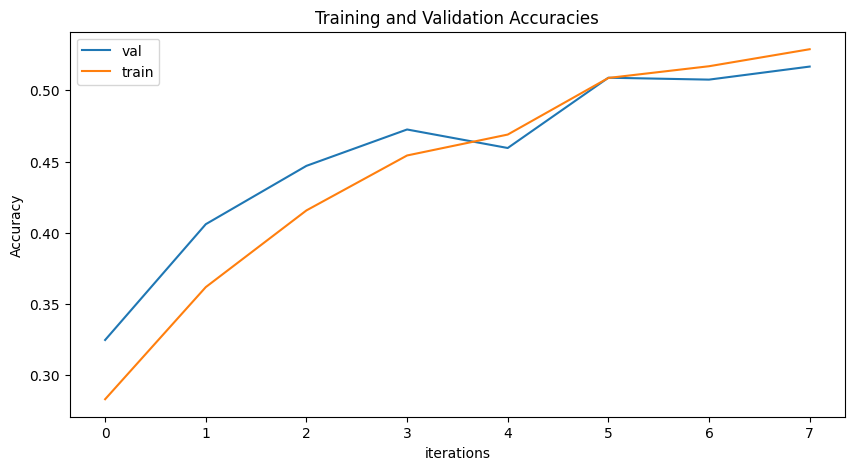

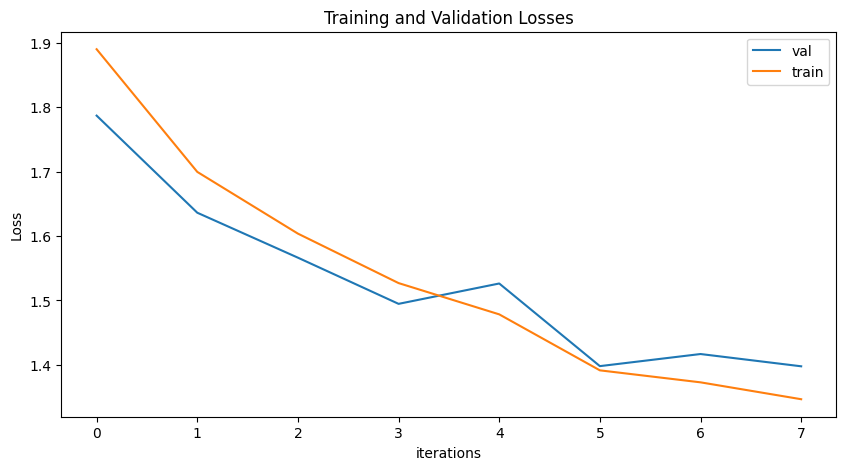

In [58]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fma_vit_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("fma_vit_loss.png")
plt.show()

In [59]:
results = evaluate_model(model, loader_test_fma_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.5268
  - Track Accuracy:  0.5788
  - Precision:       0.5357
  - Recall:          0.5269
  - F1 Score:        0.5250


In [64]:
ds_train_fma_cnn = RandomWindowSpectrogramDataset(train_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True, augment=True)
ds_val_fma_cnn = EvaluationSpectrogramDataset(val_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)
ds_test_fma_cnn = EvaluationSpectrogramDataset(test_df_fma, BASE_PATH, 'fma', window_size=128, imagenet=True, img_size=(224, 224), pretrained=True)

loader_train_fma_cnn = DataLoader(ds_train_fma_cnn, batch_size=128, shuffle=True)
loader_val_fma_cnn = DataLoader(ds_val_fma_cnn, batch_size=16, shuffle=False)
loader_test_fma_cnn = DataLoader(ds_test_fma_cnn, batch_size=16, shuffle=False)

In [65]:
model = timm.create_model("deit_tiny_patch16_224", pretrained=True, num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)

train_accs, val_accs, train_losses, val_losses = train_model(model, device, 8, optimizer, criterion, scheduler, 1, loader_train_fma_cnn, loader_val_fma_cnn)

Epoch 1/8 - loss: 2.0383, accuracy: 0.2146
Epoch 1/8 - validation per-window accuracy: 0.2717, validation majority accuracy: 0.2754, loss: 1.8947
Epoch 2/8 - loss: 1.8337, accuracy: 0.2956
Epoch 2/8 - validation per-window accuracy: 0.3459, validation majority accuracy: 0.3576, loss: 1.7741
Epoch 3/8 - loss: 1.7352, accuracy: 0.3382
Epoch 3/8 - validation per-window accuracy: 0.3613, validation majority accuracy: 0.3787, loss: 1.7022
Epoch 4/8 - loss: 1.6933, accuracy: 0.3682
Epoch 4/8 - validation per-window accuracy: 0.3807, validation majority accuracy: 0.3944, loss: 1.6756
Epoch 5/8 - loss: 1.6183, accuracy: 0.4028
Epoch 5/8 - validation per-window accuracy: 0.4445, validation majority accuracy: 0.4695, loss: 1.5573
Epoch 6/8 - loss: 1.5404, accuracy: 0.4415
Epoch 6/8 - validation per-window accuracy: 0.4524, validation majority accuracy: 0.4820, loss: 1.5387
Epoch 7/8 - loss: 1.5037, accuracy: 0.4585
Epoch 7/8 - validation per-window accuracy: 0.4606, validation majority accuracy:

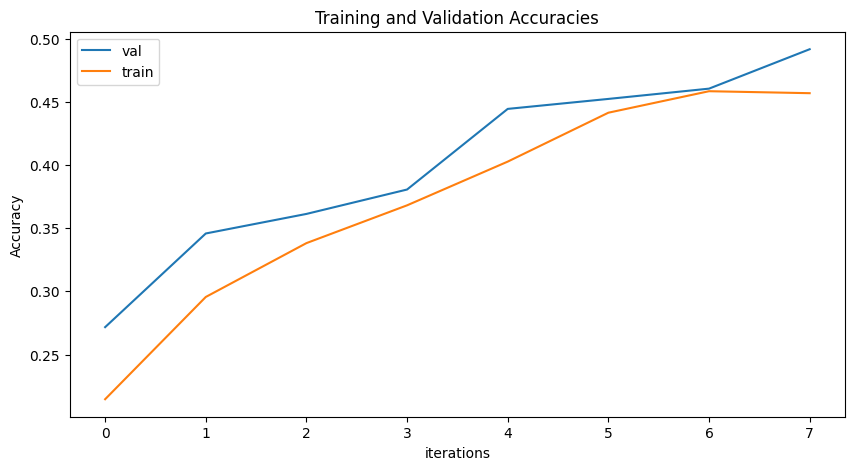

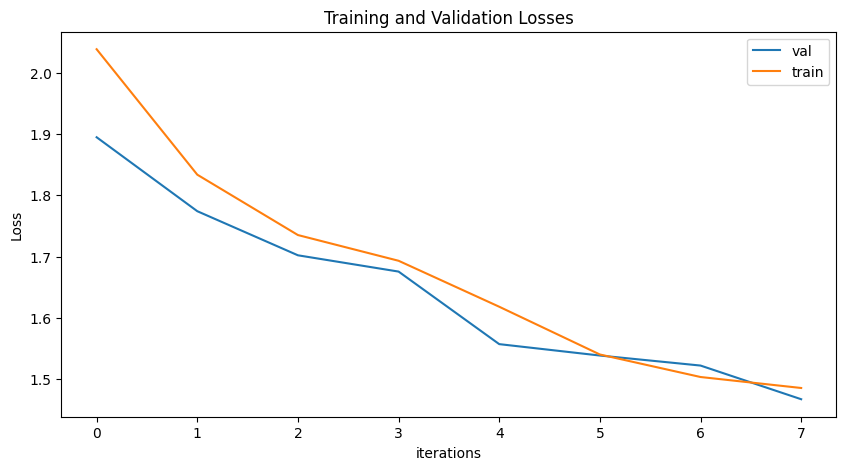

In [66]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fma_vit_acc.png")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.ylim((0, 2.5))
plt.legend()
plt.savefig("fma_vit_loss.png")
plt.show()

In [67]:
results = evaluate_model(model, loader_test_fma_cnn, criterion, device)

Evaluation:
  - Window Accuracy: 0.5103
  - Track Accuracy:  0.5507
  - Precision:       0.4953
  - Recall:          0.5105
  - F1 Score:        0.4907
